In [157]:
from nni.nas.nn.pytorch import Cell, LayerChoice, InputChoice, ModelSpace, MutableModule
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import numpy as np

906 runs loaded.


Text(0.5, 1.0, 'RadarCell: Parameters vs Inference Time')

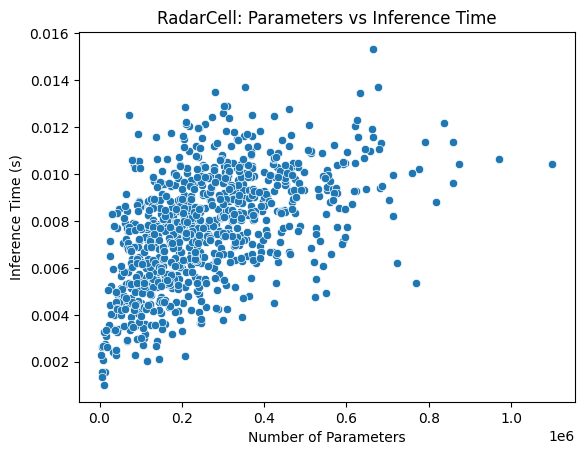

In [193]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
df = pd.read_csv("exploration_with_training_no_weight_init.csv")
df = df.replace([np.inf, -np.inf, np.nan], 0)
print(f"{df.shape[0]} runs loaded.")
# df["log_lambda_0"] = np.log10(df["ntk_lambda_0"])
# df = df[df['final_val_loss'] < 0.7]  # Filter out invalid runs
sns.scatterplot(data=df, x="params", y="inference_time")
plt.xlabel("Number of Parameters")
plt.ylabel("Inference Time (s)")
plt.title("RadarCell: Parameters vs Inference Time")

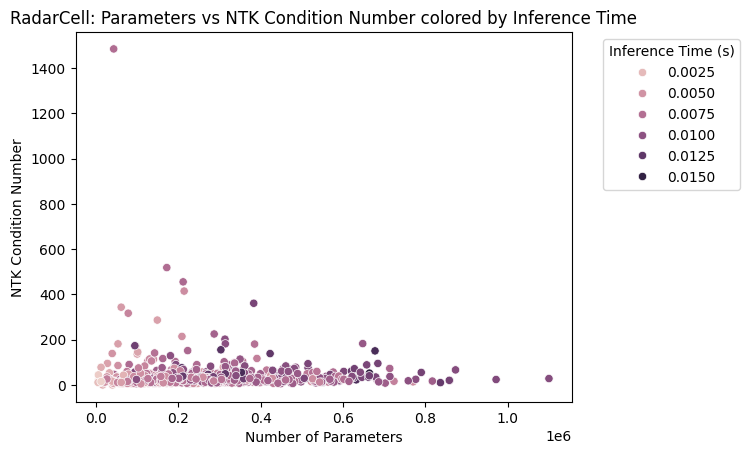

In [194]:
sns.scatterplot(data=df, x="params", y="ntk_condition_number", hue="inference_time")
plt.xlabel("Number of Parameters")
plt.ylabel("NTK Condition Number")
plt.title("RadarCell: Parameters vs NTK Condition Number colored by Inference Time")
plt.legend(title="Inference Time (s)", bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

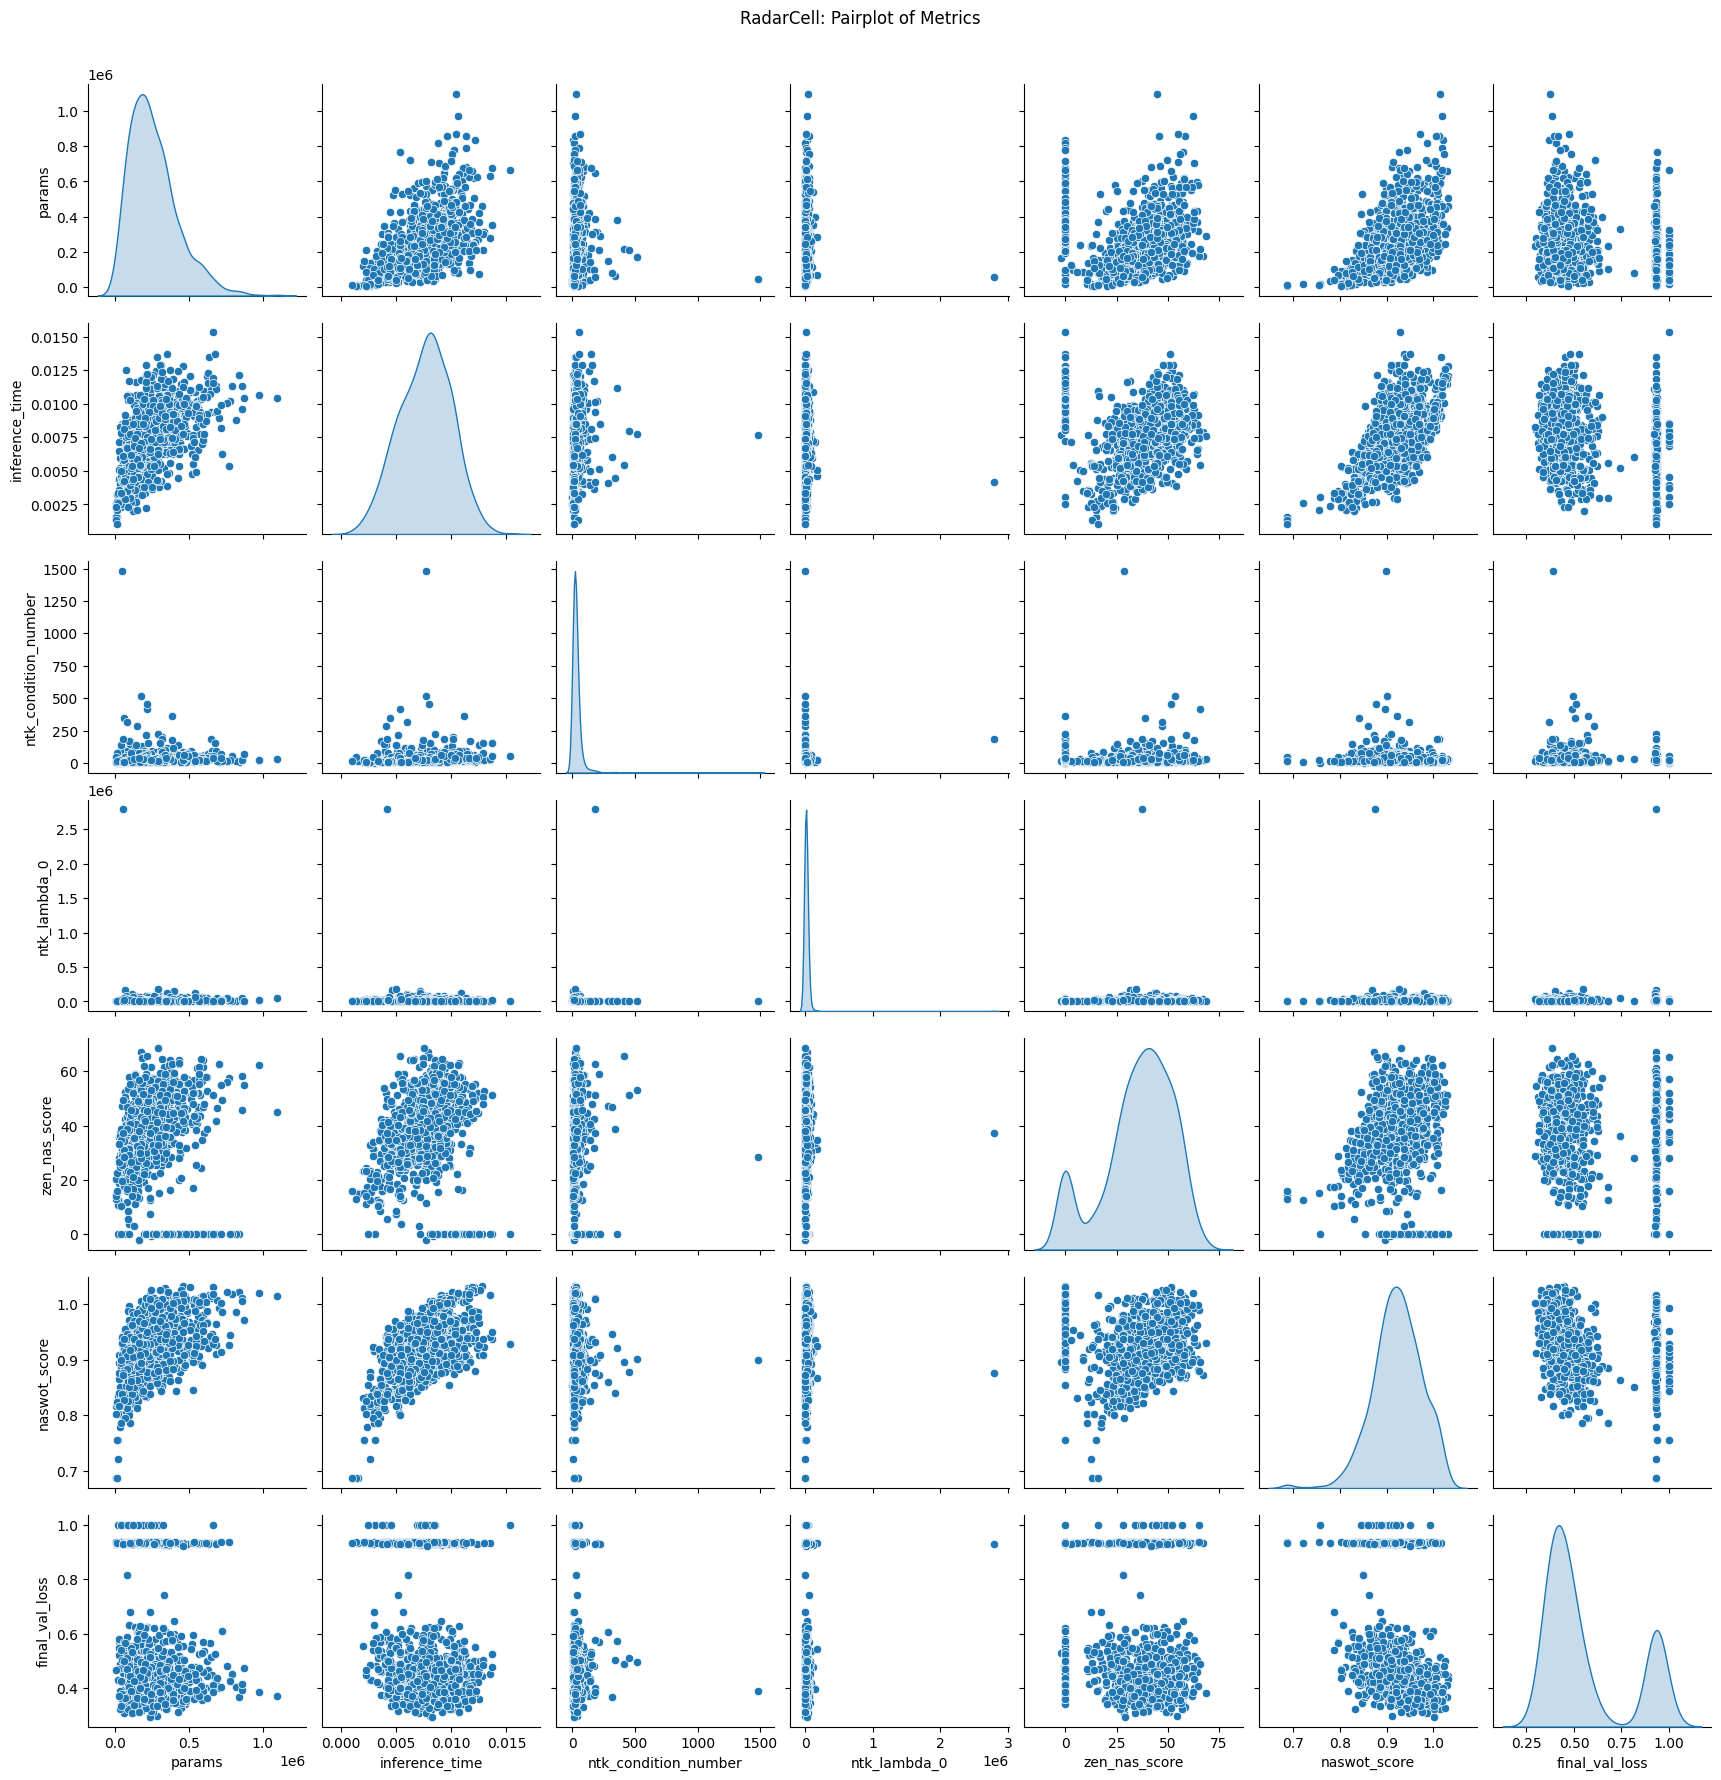

In [195]:
sns.pairplot(df, vars=["params", "inference_time", "ntk_condition_number", "ntk_lambda_0", "zen_nas_score", "naswot_score", "final_val_loss"],
              diag_kind="kde")
plt.suptitle("RadarCell: Pairplot of Metrics", y=1.02)
plt.show()

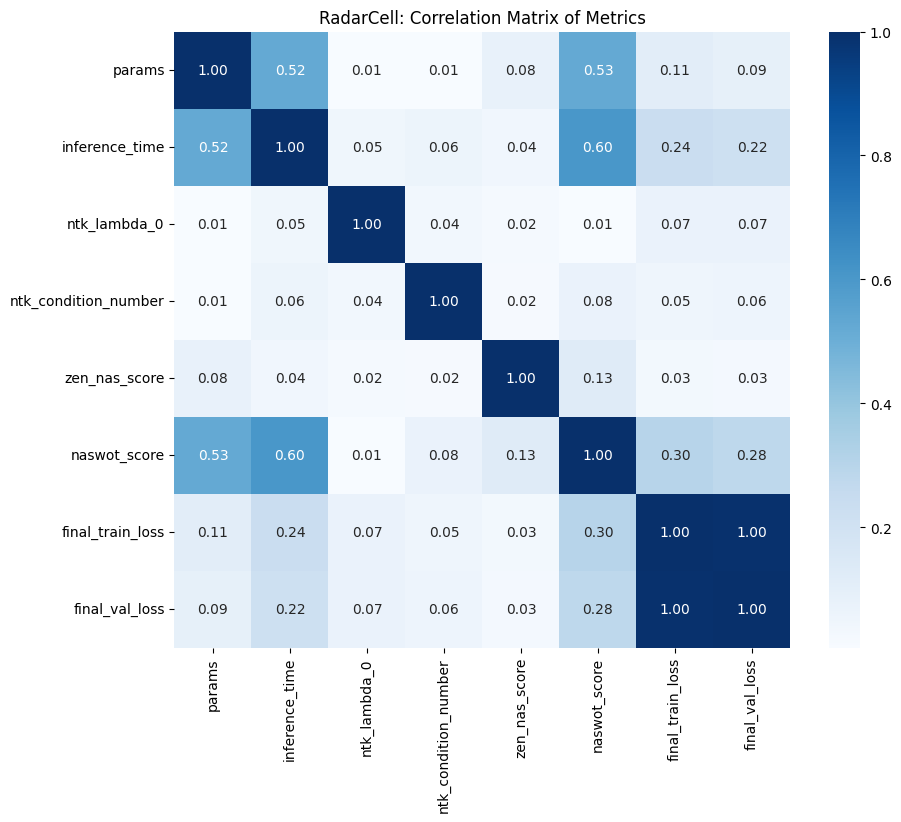

In [196]:
df_corr = df[df.columns[1:]]
corr_matrix = np.abs(df_corr.corr("pearson"))
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap="Blues", square=True)
plt.title("RadarCell: Correlation Matrix of Metrics")
plt.show()

In [197]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_squared_error

# Prepare the features and target
X = df[['ntk_lambda_0', 'ntk_condition_number', 'zen_nas_score', 'naswot_score']].copy()
X['log_ntk_lambda_0'] = np.log10(X['ntk_lambda_0'])
X = X[['log_ntk_lambda_0', 'ntk_condition_number', 'zen_nas_score', 'naswot_score']]
print(np.max(X["zen_nas_score"]), np.min(X["zen_nas_score"]))
y = df['final_val_loss']

# Fit linear regression
model = LinearRegression()
model.fit(X, y)

# Get predictions
y_pred = model.predict(X)

# Print results
print("Linear Regression Results:")
print(f"R² Score: {r2_score(y, y_pred):.4f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y, y_pred)):.4f}")
print(f"\nIntercept: {model.intercept_:.4f}")
print("\nCoefficients:")
for feature, coef in zip(X.columns, model.coef_):
    print(f"  {feature}: {coef:.4f}")

68.75144449869792 -2.1104774475097656


/home/lam/anaconda3/envs/moo_py38/lib/python3.11/site-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)


ValueError: Input X contains NaN.
LinearRegression does not accept missing values encoded as NaN natively. For supervised learning, you might want to consider sklearn.ensemble.HistGradientBoostingClassifier and Regressor which accept missing values encoded as NaNs natively. Alternatively, it is possible to preprocess the data, for instance by using an imputer transformer in a pipeline or drop samples with missing values. See https://scikit-learn.org/stable/modules/impute.html You can find a list of all estimators that handle NaN values at the following page: https://scikit-learn.org/stable/modules/impute.html#estimators-that-handle-nan-values

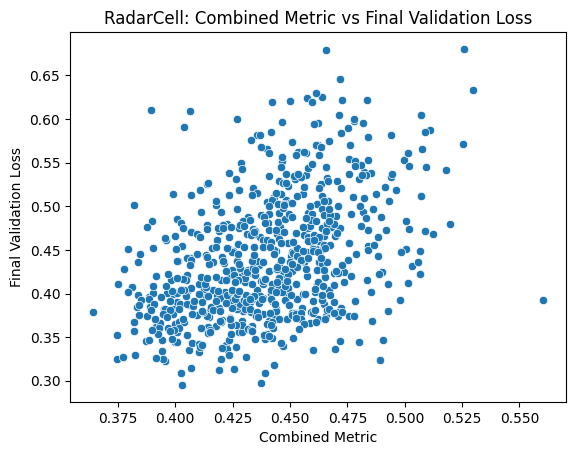

0.43107695641429195


In [ ]:
new_metric = (model.intercept_ +
              model.coef_[0] * X['log_ntk_lambda_0'] +
              model.coef_[1] * X['ntk_condition_number'] +
              model.coef_[2] * X['zen_nas_score'] +
              model.coef_[3] * X['naswot_score'])
sns.scatterplot(x=new_metric, y=y)
plt.xlabel("Combined Metric")
plt.ylabel("Final Validation Loss")
plt.title("RadarCell: Combined Metric vs Final Validation Loss")
plt.show()
print(np.corrcoef(new_metric, y)[0, 1])